# Agreement Between Models

Imports and Constants

**Section 1:** 1 eV window

**Section 1.1:** Inputting Data and Clustering

**Section 1.2:** AMI with Noise

**Section 1.3:** AMI removing Noise


In [1]:
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
import numpy as np
import pandas as pd
from pathlib import Path
from itertools import product
import hdbscan
import seaborn as sns
import matplotlib.pyplot as plt

CLUSTER_SIZE = 3
SAMPLE_MIN = 2

## Section 1: 1 eV Window

## 1.1: Inputting Data and Clustering

For this code, we are only considering a window size of 1 eV. It can easily be adjusted to check other window sizes, or the entire ensamble, by updating the window_size_param variable.

In [2]:
path = Path("../explorer/fingerprints")

resnet_version_param = [18, 50]
latent_space_dim_param = [1, 2, 3]
window_size_param = [1]
training_steps_param = [30, 60, 90, 120]
train_test_split_param = [0, 0.1, 0.5]
line_width_param = [1]

parameters = product(resnet_version_param, latent_space_dim_param, window_size_param, 
                     training_steps_param, train_test_split_param, line_width_param)


parameters = list(parameters)
num_models = len(parameters)

clusters = []
num_clusters_per_model = []

for resnet_version, latent_space_dim, window_size, training_steps, train_test_split, line_width in parameters:
    model = f"resnet{resnet_version}_latent{latent_space_dim}_window{window_size}eV_steps{training_steps}_split{train_test_split * 10}_width{line_width}_.csv"
    model_path = path / model
    csv = pd.read_csv(model_path)

    x = csv.filter(like="z").to_numpy()

    clusterer = hdbscan.HDBSCAN(algorithm='best', alpha=1.0, approx_min_span_tree=True,
                gen_min_span_tree=True, leaf_size=40, metric='minkowski', 
                cluster_selection_method='eom', min_cluster_size=CLUSTER_SIZE, 
                min_samples=SAMPLE_MIN, p=0.2)

    labels = clusterer.fit_predict(x)
    clusters.append(labels)

    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = np.sum(labels == -1)

    cluster_info = {"n_clusters": n_clusters, "n_noise": n_noise}
    num_clusters_per_model.append(cluster_info)

/home/justin/miniconda3/envs/myenv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/justin/miniconda3/envs/myenv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/justin/miniconda3/envs/myenv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/justin/miniconda3/envs/myenv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/justin/miniconda3/envs/myenv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_

In [3]:
print(num_clusters_per_model)

[{'n_clusters': 46, 'n_noise': np.int64(311)}, {'n_clusters': 33, 'n_noise': np.int64(241)}, {'n_clusters': 16, 'n_noise': np.int64(115)}, {'n_clusters': 26, 'n_noise': np.int64(197)}, {'n_clusters': 18, 'n_noise': np.int64(131)}, {'n_clusters': 34, 'n_noise': np.int64(311)}, {'n_clusters': 24, 'n_noise': np.int64(233)}, {'n_clusters': 2, 'n_noise': np.int64(25)}, {'n_clusters': 27, 'n_noise': np.int64(220)}, {'n_clusters': 2, 'n_noise': np.int64(46)}, {'n_clusters': 23, 'n_noise': np.int64(160)}, {'n_clusters': 38, 'n_noise': np.int64(306)}, {'n_clusters': 2, 'n_noise': np.int64(15)}, {'n_clusters': 41, 'n_noise': np.int64(308)}, {'n_clusters': 39, 'n_noise': np.int64(297)}, {'n_clusters': 2, 'n_noise': np.int64(10)}, {'n_clusters': 2, 'n_noise': np.int64(12)}, {'n_clusters': 51, 'n_noise': np.int64(295)}, {'n_clusters': 2, 'n_noise': np.int64(19)}, {'n_clusters': 44, 'n_noise': np.int64(304)}, {'n_clusters': 45, 'n_noise': np.int64(291)}, {'n_clusters': 2, 'n_noise': np.int64(15)}, {

## 1.2: AMI with Noise

In [4]:
rand_scores_noised = np.zeros([num_models, num_models])
ami_scores_noised = np.zeros([num_models, num_models])

for i in range(num_models):
    for j in range(i, num_models): 
        rand_score = adjusted_rand_score(clusters[i], clusters[j])
        rand_scores_noised[i, j] = rand_score
        rand_scores_noised[j, i] = rand_score  

        ami_score = adjusted_mutual_info_score(clusters[i], clusters[j])
        ami_scores_noised[i, j] = ami_score
        ami_scores_noised[j, i] = ami_score  

In [5]:
ami_no_diag = ami_scores_noised.copy()
np.fill_diagonal(ami_no_diag, np.nan)  

row_means = np.nanmean(ami_no_diag, axis=1)

best_model_index = np.nanargmax(row_means)

print(f"Best model index: {best_model_index}")
print(f"Average AMI: {row_means[best_model_index]:.4f}")

print(parameters[best_model_index])
print(num_clusters_per_model[best_model_index])

ami_no_diag = ami_scores_noised.copy()
np.fill_diagonal(ami_no_diag, np.nan)  

row_means = np.nanmean(ami_no_diag, axis=1)

# Get ranking indices sorted from best to worst
ranking_indices = np.argsort(row_means)[::-1]

print("\n=== Ranked Models by Average AMI ===")
for rank, idx in enumerate(ranking_indices):
    avg_ami = row_means[idx]
    param = parameters[idx]
    cluster_info = num_clusters_per_model[idx]
    print(f"{rank + 1:2d}. AMI: {avg_ami:.4f} | Index: {idx} | Params: {param} | Clusters: {cluster_info}")


Best model index: 28
Average AMI: 0.4567
(18, 3, 1, 60, 0.1, 1)
{'n_clusters': 43, 'n_noise': np.int64(296)}

=== Ranked Models by Average AMI ===
 1. AMI: 0.4567 | Index: 28 | Params: (18, 3, 1, 60, 0.1, 1) | Clusters: {'n_clusters': 43, 'n_noise': np.int64(296)}
 2. AMI: 0.4477 | Index: 61 | Params: (50, 3, 1, 30, 0.1, 1) | Clusters: {'n_clusters': 44, 'n_noise': np.int64(297)}
 3. AMI: 0.4445 | Index: 19 | Params: (18, 2, 1, 90, 0.1, 1) | Clusters: {'n_clusters': 44, 'n_noise': np.int64(304)}
 4. AMI: 0.4431 | Index: 67 | Params: (50, 3, 1, 90, 0.1, 1) | Clusters: {'n_clusters': 45, 'n_noise': np.int64(299)}
 5. AMI: 0.4416 | Index: 31 | Params: (18, 3, 1, 90, 0.1, 1) | Clusters: {'n_clusters': 43, 'n_noise': np.int64(273)}
 6. AMI: 0.4396 | Index: 65 | Params: (50, 3, 1, 60, 0.5, 1) | Clusters: {'n_clusters': 41, 'n_noise': np.int64(280)}
 7. AMI: 0.4379 | Index: 13 | Params: (18, 2, 1, 30, 0.1, 1) | Clusters: {'n_clusters': 41, 'n_noise': np.int64(308)}
 8. AMI: 0.4362 | Index: 63

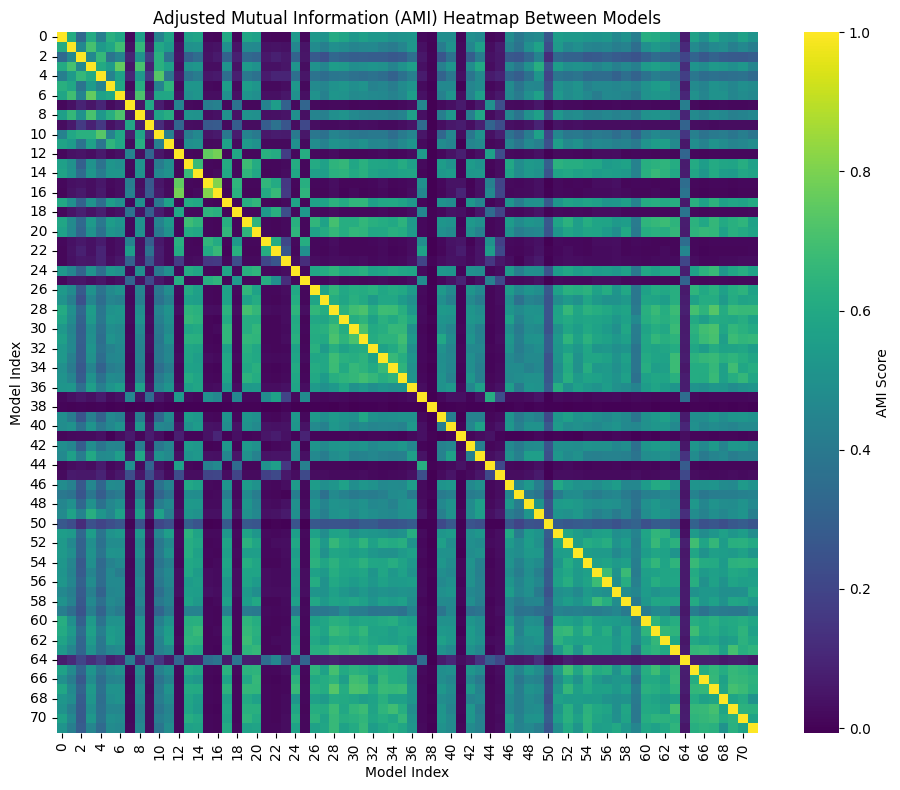

In [6]:
plt.figure(figsize=(10, 8))
sns.heatmap(ami_scores_noised, annot=False, cmap="viridis", square=True, cbar_kws={"label": "AMI Score"})
plt.title("Adjusted Mutual Information (AMI) Heatmap Between Models")
plt.xlabel("Model Index")
plt.ylabel("Model Index")
plt.tight_layout()
plt.show()

## 1.3: AMI Removing Noise

In [7]:
def filtered_rand_ami(labels1, labels2):
    mask = (labels1 != -1) & (labels2 != -1)
    if np.sum(mask) == 0:
        return np.nan, np.nan
    l1 = labels1[mask]
    l2 = labels2[mask]
    rand = adjusted_rand_score(l1, l2)
    ami = adjusted_mutual_info_score(l1, l2)
    return rand, ami

rand_scores = np.zeros([num_models, num_models])
ami_scores = np.zeros([num_models, num_models])

for i in range(num_models):
    for j in range(i, num_models):
        rand, ami = filtered_rand_ami(clusters[i], clusters[j])
        rand_scores[i, j] = rand_scores[j, i] = rand
        ami_scores[i, j] = ami_scores[j, i] = ami

In [8]:
ami_no_diag = ami_scores.copy()
np.fill_diagonal(ami_no_diag, np.nan)  

row_means = np.nanmean(ami_no_diag, axis=1)

best_model_index = np.nanargmax(row_means)

print(f"Best model index: {best_model_index}")
print(f"Average AMI: {row_means[best_model_index]:.4f}")

print(parameters[best_model_index])
print(num_clusters_per_model[best_model_index])

ami_no_diag = ami_scores.copy()
np.fill_diagonal(ami_no_diag, np.nan)  

row_means = np.nanmean(ami_no_diag, axis=1)

# Get ranking indices sorted from best to worst
ranking_indices = np.argsort(row_means)[::-1]

print("\n=== Ranked Models by Average AMI ===")
for rank, idx in enumerate(ranking_indices):
    avg_ami = row_means[idx]
    param = parameters[idx]
    cluster_info = num_clusters_per_model[idx]
    print(f"{rank + 1:2d}. AMI: {avg_ami:.4f} | Index: {idx} | Params: {param} | Clusters: {cluster_info}")


Best model index: 13
Average AMI: 0.6690
(18, 2, 1, 30, 0.1, 1)
{'n_clusters': 41, 'n_noise': np.int64(308)}

=== Ranked Models by Average AMI ===
 1. AMI: 0.6690 | Index: 13 | Params: (18, 2, 1, 30, 0.1, 1) | Clusters: {'n_clusters': 41, 'n_noise': np.int64(308)}
 2. AMI: 0.6683 | Index: 26 | Params: (18, 3, 1, 30, 0.5, 1) | Clusters: {'n_clusters': 40, 'n_noise': np.int64(312)}
 3. AMI: 0.6662 | Index: 24 | Params: (18, 3, 1, 30, 0, 1) | Clusters: {'n_clusters': 40, 'n_noise': np.int64(321)}
 4. AMI: 0.6654 | Index: 28 | Params: (18, 3, 1, 60, 0.1, 1) | Clusters: {'n_clusters': 43, 'n_noise': np.int64(296)}
 5. AMI: 0.6628 | Index: 29 | Params: (18, 3, 1, 60, 0.5, 1) | Clusters: {'n_clusters': 41, 'n_noise': np.int64(303)}
 6. AMI: 0.6617 | Index: 68 | Params: (50, 3, 1, 90, 0.5, 1) | Clusters: {'n_clusters': 42, 'n_noise': np.int64(320)}
 7. AMI: 0.6608 | Index: 65 | Params: (50, 3, 1, 60, 0.5, 1) | Clusters: {'n_clusters': 41, 'n_noise': np.int64(280)}
 8. AMI: 0.6593 | Index: 67 |

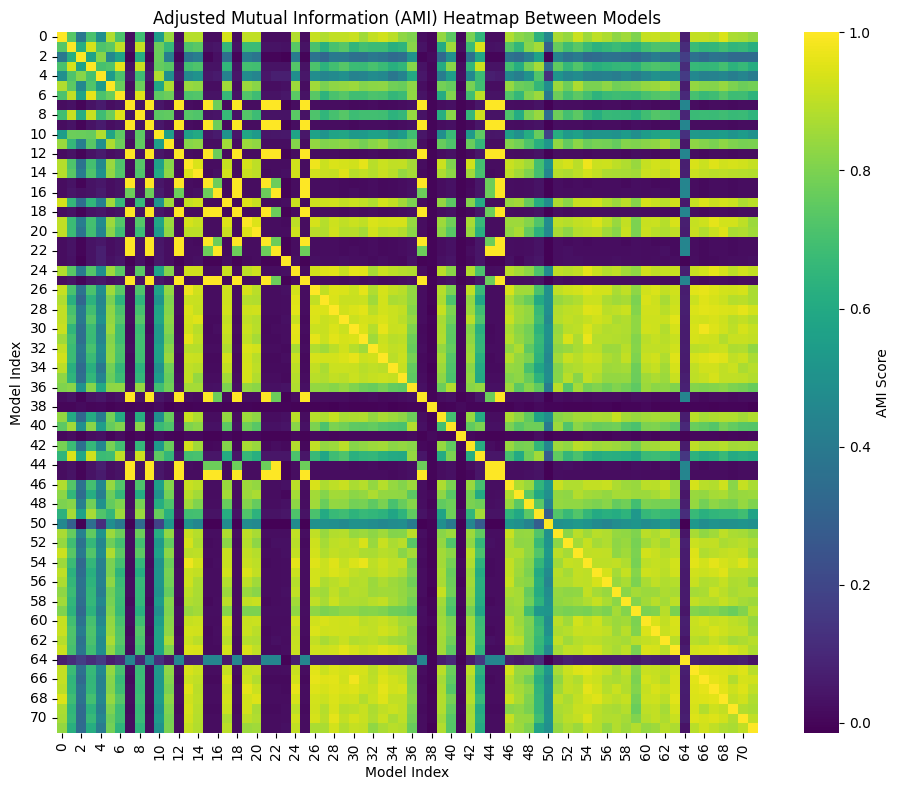

In [9]:
plt.figure(figsize=(10, 8))
sns.heatmap(ami_scores, annot=False, cmap="viridis", square=True, cbar_kws={"label": "AMI Score"})
plt.title("Adjusted Mutual Information (AMI) Heatmap Between Models")
plt.xlabel("Model Index")
plt.ylabel("Model Index")
plt.tight_layout()
plt.show()

As there is a large amount of noise in these clusters, many extra points can be removed, so we check which have noise in common

Best model index: 60
Average Noise: 0.5236
(50, 3, 1, 30, 0, 1)
{'n_clusters': 44, 'n_noise': np.int64(312)}


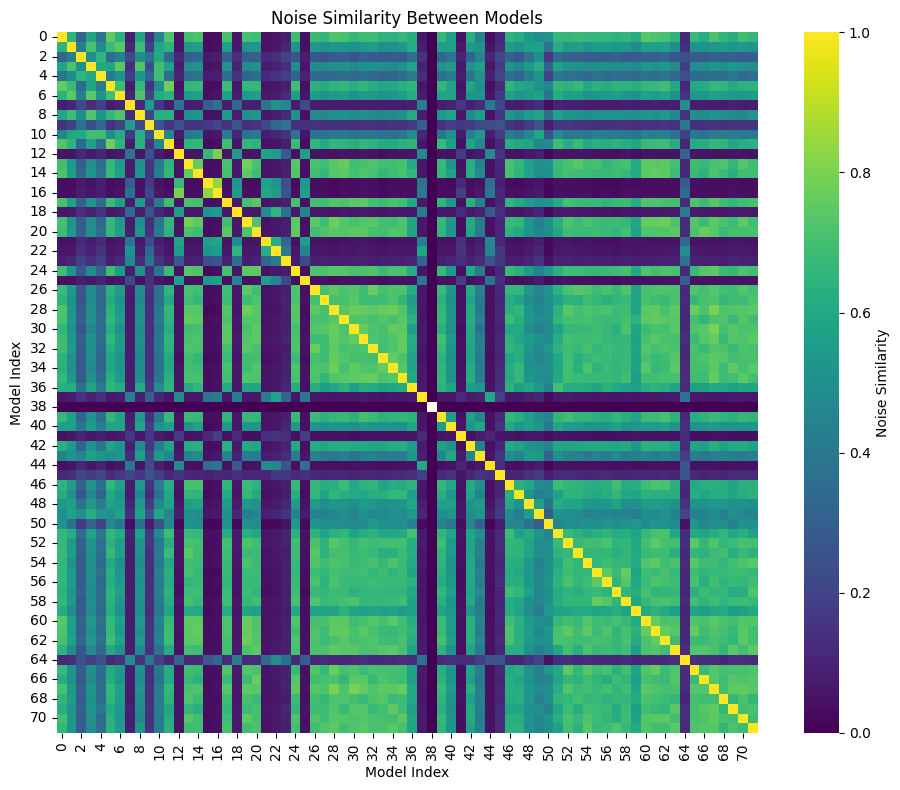

In [10]:
# Looking at Noise

noise_similarity = np.zeros((num_models, num_models))

for i in range(num_models):
    noise_i = clusters[i] == -1
    for j in range(i, num_models):
        noise_j = clusters[j] == -1

        intersection = np.logical_and(noise_i, noise_j).sum()
        union = np.logical_or(noise_i, noise_j).sum()

        if union == 0:
            score = np.nan  # no noise in either = undefined
        else:
            score = intersection / union

        noise_similarity[i, j] = score
        noise_similarity[j, i] = score  # symmetric

noise_no_diagonal = noise_similarity.copy()
np.fill_diagonal(noise_no_diagonal, np.nan)  

row_means = np.nanmean(noise_no_diagonal, axis=1)

best_model_index = np.nanargmax(row_means)

print(f"Best model index: {best_model_index}")
print(f"Average Noise: {row_means[best_model_index]:.4f}")

print(parameters[best_model_index])
print(num_clusters_per_model[best_model_index])

plt.figure(figsize=(10, 8))
sns.heatmap(noise_similarity, annot=False, cmap="viridis", square=True, cbar_kws={"label": "Noise Similarity"})
plt.title("Noise Similarity Between Models")
plt.xlabel("Model Index")
plt.ylabel("Model Index")
plt.tight_layout()
plt.show()